# 1. Imporing PyTorch and setting up device-agnostic code

In [55]:
#creating responsive plot
%matplotlib widget

# Import packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal, lognorm, expon, powerlaw
from sklearn.utils import shuffle
from typing import Dict, List
#import platform
import os 

In [3]:
# Import torchvision
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Check version
print(f'Pytorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}\n')

# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
if device == 'cuda':
    print(torch.cuda.get_device_name(0))
    gpu_memory_info = torch.cuda.get_device_properties(0)
    total_memory = gpu_memory_info.total_memory / (1024 ** 3)  # Convert to GB
    free_memory = torch.cuda.memory_reserved(0) / (1024 ** 3)  # Convert to GB
    used_memory = torch.cuda.memory_allocated(0) / (1024 ** 3)  # Convert to GB
    print(f"\nTotal GPU Memory: {total_memory:.2f} GB")
    print(f"Free GPU Memory: {free_memory:.2f} GB")
    print(f"Used GPU Memory: {used_memory:.2f} GB")
else:
    print("CUDA is not available.")

Pytorch version: 2.2.2
Torchvision version: 0.17.2

NVIDIA GeForce RTX 2070

Total GPU Memory: 8.00 GB
Free GPU Memory: 0.00 GB
Used GPU Memory: 0.00 GB


# 2. Functions

## 2.1 Functions for generating and manipulating structure

In [190]:
def generate_ratios(mean, cov, distribution='gaussian'):
    # if distribution == 'lognormal':
    #     # Use the mean and standard deviation to create log-normal distribution
    #     mean_a_c, mean_b_c = mean
    #     var_a_c, var_b_c = np.diag(cov)
    #     s_a_c = np.sqrt(var_a_c)
    #     s_b_c = np.sqrt(var_b_c)
        
    #     # Generate a/c and b/c from log-normal distributions
    #     a_c = lognorm.rvs(s=s_a_c, scale=np.exp(mean_a_c))
    #     b_c = lognorm.rvs(s=s_b_c, scale=np.exp(mean_b_c))
    if distribution == 'lognormal':
        # Adjust to ensure the mean is approximately 1
        sigma = np.sqrt(np.log(1 + (cov[0][0] / mean[0]**2)))  # Standard deviation of the lognormal
        mu = np.log(mean[0]) - 0.5 * sigma**2  # Adjusted mean
        a_c = lognorm.rvs(s=sigma, scale=np.exp(mu))
        
        sigma_b = np.sqrt(np.log(1 + (cov[1][1] / mean[1]**2)))
        mu_b = np.log(mean[1]) - 0.5 * sigma_b**2
        b_c = lognorm.rvs(s=sigma_b, scale=np.exp(mu_b))
        
    elif distribution == 'exponential':
        # Use the mean as the scale parameter for exponential distribution
        a_c = expon.rvs(scale=mean[0])
        b_c = expon.rvs(scale=mean[1])
    
    elif distribution == 'powerlaw':
        # Generate a/c and b/c from a power law distribution
        # The parameter `a` controls the shape of the distribution
        a_c = powerlaw.rvs(a=mean[0], scale=1)
        b_c = powerlaw.rvs(a=mean[1], scale=1)
    
    else:  # Gaussian by default
        # Generate ratios from a 2D Gaussian distribution
        a_c, b_c = multivariate_normal.rvs(mean, cov)
    
    return a_c, b_c

In [47]:
""" Functions that are used to generate filled sphere and elipsoid"""
# Generate points on surface of sphere
def sphere(radius, num_points, plot=False):
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points) * radius)
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        plt.gca().set_aspect('auto', adjustable='box')
        ax.scatter(x,y,z, marker='.')
        ax.set_aspect('equal', 'box') #auto adjust limits
        #ax.axis('equal')
        ax.set_title('Structure of Circle', fontsize=10)
        plt.show()

    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

def ellipsoid(radius, num_points, mean, cov, distribution='gaussian', plot=False):
    # Generate random angles and radius for spherical coordinates
    u = np.random.rand(num_points) 
    v = np.random.rand(num_points) 
    r = np.cbrt(np.random.rand(num_points))
     
    theta = u * 2 * np.pi
    phi = v * np.pi

    # Generate a/c and b/c ratios
    a_c, b_c = generate_ratios(mean, cov, distribution)

    # Generate ellipsoid coordinates with the scaling factors
    x = a_c * radius * r * np.sin(phi) * np.cos(theta)
    y = b_c * radius * r * np.sin(phi) * np.sin(theta)
    z = radius * r * np.cos(phi)  # Here c is set to radius

    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, marker='.')
        ax.set_title(f'Ellipsoid with a/c={a_c:.2f}, b/c={b_c:.2f}')
        ax.axis('equal')
        plt.show()
    
    # Return points as list of tuples
    points = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    return points

In [9]:
def rotation(structure):
    point_cloud = structure
    
    # Convert to homogeneous coordinates
    point_cloud_homogeneous = []
    for point in structure:
        point_homogeneous = np.append(point,1)
        point_cloud_homogeneous.append(point_homogeneous)
    
    x, y, z= np.random.uniform(low = 0, high = 2 * np.pi, size=3)
    
    cx, sx = np.cos(x), np.sin(x)
    cy, sy = np.cos(y), np.sin(y)
    cz, sz = np.cos(z), np.sin(z)
    
    rotate_x = np.array([
        [1, 0, 0, 0],
        [0, cx, -sx, 0],
        [0, sx, cx, 0],
        [0, 0, 0, 1],
        ])

    rotate_y = np.array([
        [cy, 0, sy, 0],
        [0, 1, 0, 0],
        [-sy, 0, cy, 0],
        [0, 0, 0, 1],
        ])

    rotate_z = np.array([
        [cy, -sy, 0, 0],
        [-sy, cy, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        ])

    # Rotate in a 3 axis
    rotated_points = np.matmul(
        point_cloud_homogeneous,
        rotate_x)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_y)
    
    rotated_points = np.matmul(
        rotated_points,
        rotate_z)
    
    # Convert to cartesian coordinates
    rotated_points_xyz = []
    for point in rotated_points:
        point = np.array(point[:-1])
        rotated_points_xyz.append(point)

    return np.array(rotated_points_xyz)

## 2.2 Function for Projecting 3D coordinates to 2D images

In [11]:
 """ Functions for projection """
def points_projection(structure_coords, num_points):
    # Assign structure coords into z
    z = structure_coords
    
    # normal vectors generation
    normal = sphere(1, num_points)

    all_projected_points = []
    for n in normal:
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            
        all_projected_points.append(projected_points)

    return np.array(all_projected_points)


def cluster_per_cell(projected_points, image_size, grid_size):
    '''
    Transforms projectied points into greyscale image (0-1 range)
    '''
    all_projections = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    all_grid = []
    for projection in all_projections:
        grid = np.zeros((grid_x,grid_y), dtype=int)
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projection, axis=0)
        max_val = np.max(projection, axis=0)
        
        #Feature scaling 
        points_norm = (projection - min_val) / (max_val - min_val) 
        
        scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
        
        for points in scaled_points:
            x,y = points
            gridx_index = int(x // cell_x) #floor division followed by conversion to integer
            gridy_index = int(y // cell_y)
            grid[gridy_index, gridx_index] += 1
            
        all_grid.append(grid)
        
    # transform into bw image 
    all_images = []
    for grid_img in all_grid:
        min = np.min(grid_img)
        max = np.max(grid_img)
        points_norm = (grid_img - min) / (max - min) 
        all_images.append(points_norm)

    return  all_images


def image_projection(coords, size):
    '''
    # Transform projected points into black and white image (1s and 0s)
    '''
    all_projects = np.array(coords)
    image_size = size

    all_images = []
    for projects in all_projects:
    
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projects, axis=0)
        max_val = np.max(projects, axis=0)
        
        #Feature scaling 
        points_norm = (projects - min_val) / (max_val - min_val) 
        
        # Scale points to image size
        points_scaled = (points_norm * (np.array(image_size) -1 )).astype(int)
        
        # Create an empty image
        image = np.zeros(image_size)
        
        # Populate the image with points
        for point in points_scaled:
            x, y = point
            image[y,x] = 1  # Note: (y, x) because image coordinates are row-major
        
        all_images.append(image)
    
    return all_images


## 2.3 Functions for plottting

In [51]:
def plot_images(image1, image2, image3, image4, filename):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    images = [image1, image2, image3, image4]
    titles = ['Sphere System 1', 'Sphere System 2', 'Ellipsoid System 1', 'Ellipsoid System 2']

    for idx, image in enumerate(images):
        # Determine the position in the 2x2 grid
        ax = axs[idx // 2, idx % 2]
        
        # Display the image
        ax.imshow(image, cmap='gray')
        
        # Set the predefined title for each subplot
        ax.set_title(titles[idx], fontsize=10)
        
        ax.axis('off')  # Hide the axes for a cleaner look

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.close(fig)
    
def plot_loss_curves(results: Dict[str, List[float]],filename):
    """ Plots training curves of a result dictionary """
    # Get loss value of result dictionary(training and testing)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get accuracy values of the result dictionary (training and testing)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    #Figure out no of epochs
    epochs = range(len(results["train_loss"]))
    
    #Setup plot
    # Setup plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the loss
    ax[0].plot(epochs, loss, label="Train_loss")
    ax[0].plot(epochs, test_loss, label="Test_loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].legend()

    # Plot the accuracy
    ax[1].plot(epochs, accuracy, label="Train_accuracy")
    ax[1].plot(epochs, test_accuracy, label="Test_accuracy")
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].legend()

    # Save the figure
    plt.savefig(f'{filename}.png')
    plt.close(fig)

"""Plots 3D scatter plots of structure"""
def plot_structure(structure1, structure2, structure3, structure4):
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 16), subplot_kw={'projection': '3d'})

    structures = [structure1, structure2, structure3, structure4]

    for idx, structure in enumerate(structures):
        # Extract x, y, z coordinates for each structure
        x = structure[:, 0]
        y = structure[:, 1]
        z = structure[:, 2]
        
        # Determine the position in the 2x2 grid
        ax = axs[idx // 2, idx % 2]
        
        # Plot the structure
        ax.scatter(x, y, z, marker='.')
        ax.set_aspect('auto', adjustable='box')
        ax.set_title(f'3D plot of structure {idx+1}', fontsize=10)
        ax.axis('equal')
        ax.set_axis_off()
    

    # Adjust layout
    plt.tight_layout()
    plt.savefig('Structure_Example.png')
    plt.show()
    return

## 2.4 Pytorch Functions

In [15]:
# CNN model    
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, padding_mode='circular')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 32 * 32, 2)

    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

model = SimpleCNN()
model.to(device)
print('Model being used is SimpleCNN')

# create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # Put model in train mode
    model.train()
    
    # setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader, data batch
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device).unsqueeze(1), y.to(device)

        #1. Forward pass
        y_pred = model(X) #output model logits
        
        #2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #3. Optimizer zero grad
        optimizer.zero_grad()

        #4. Loss backward
        loss.backward()

        #5. Optimizer step
        optimizer.step()

        #6. Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred) # total no correct divided by len of sample

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# create test_step
def test_step(model:  torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    #Setup test loss and test accuract values
    test_loss, test_acc = 0, 0

    # Turn on inderence mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            #send data to target device
            X, y = X.to(device).unsqueeze(1), y.to(device)

            #1. Forward pass
            test_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            #3. Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    #Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss /  len(dataloader)
    test_acc = test_acc /  len(dataloader)
    return test_loss, test_acc


# Create train function
#1. Create a train function that takes in varius model parameters + optimizer + dataloaders
def train(model:torch.nn.Module,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device=device):

    #Create result dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # Loop through training and testing steps for x number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_data,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_data,
                                        loss_fn=loss_fn,
                                        device=device)
        #Print out what's happening
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        #Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

Model being used is SimpleCNN


## 2.5 Custom Dataset for Data and Labels

In [17]:
#Function that makes labels
def label_making(label_num, lst):
    label = [label_num] * len(lst)
    return label

# takes in data and labels to transform into dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label


# If dataset needs to be imported
# takes in data and labels to transform into dataset
class LargeNPZDataset(Dataset):
    def __init__(self, npz_file, split='train'):
        # Load only metadata initially
        self.data = np.load(npz_file, mmap_mode='r')
        self.X = self.data[f'X_{split}']
        self.y = self.data[f'y_{split}']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Load a single sample
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        
        # Convert to tensors
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_sample = torch.tensor(y_sample, dtype=torch.long)
        
        return X_sample, y_sample

## 2.6 Function for generating system and images

In [232]:
def system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res, distance_range):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_spheres = np.random.randint(5,max_spheres) # min 5 sphere per system
        distance = np.random.randint(2, distance_range) # Comment this and uncomment next line to fix distance
        # distance = distance_range
		
        for _ in range(no_of_spheres):
            a = sphere(max_sphere_size, no_of_points) # create sphere
            a = a + (np.random.rand(1,3) * np.random.randint(1,distance)) # translate sphere around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that spheres coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)
        
        del systems, proj_2D

    bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return bw_img_all, grid_img_all

def system_maker2(no_of_systems ,max_ellipsoids, max_ellipsoid_size, no_of_points, no_of_projections, image_res, distance_range, distribution_type='gaussian'):
    bw_img_all = []
    grid_img_all = []
    for _ in range(no_of_systems):
        systems = []
        no_of_ellipsoids = np.random.randint(15,max_ellipsoids) # min 5 ellipsoids per system
        distance = np.random.randint(2, distance_range) # Comment this and uncomment next line to fix distance
        # distance = distance_range
		
        for _ in range(no_of_ellipsoids):
            a = ellipsoid(radius=max_ellipsoid_size, num_points=no_of_points, mean=mean, cov=cov, distribution=distribution_type)
            a = rotation(a)
            a = a + (np.random.rand(1,3) * np.random.randint(1, distance)) # translate ellipsoids around
            systems.append(a) # add spheres
        
        systems = np.array(systems) #transform into numpy array
        systems = systems.reshape(-1 , systems.shape[-1]) # reshape so that ellipsoids coordinates in each systems combines

        # Project 3D system ontto 2D plane
        proj_2D = points_projection(systems,no_of_projections)
        
        # Transform 2D points into 1s ad 0s image & 0-1 range image
        image_bw = image_projection(proj_2D, image_res)
        image_contrast = cluster_per_cell(proj_2D, (720, 720), image_res)

        bw_img_all.append(image_bw)
        grid_img_all.append(image_contrast)
        del systems, proj_2D

    bw_img_all = np.array(bw_img_all)
    grid_img_all = np.array(grid_img_all)
    bw_img_all = bw_img_all.reshape(-1,bw_img_all.shape[-2],bw_img_all.shape[-1] )
    grid_img_all = grid_img_all.reshape(-1,grid_img_all.shape[-2],grid_img_all.shape[-1] )

    return bw_img_all, grid_img_all

# 3. Script

In [266]:
## Test script
cov_ab = 0.01  # Covariance between a/c and b/c
variance_a = 0.1  # Variance for a/c
variance_b = 0.1  # Variance for b/c

mean_a = mean_b = 1
mean = [mean_a, mean_b] # a/c, b/c
cov = [[variance_a, cov_ab], 
       [cov_ab, variance_b]]

d = 30


image_name = 'img'
loss_name = 'simple_loss'

In [272]:
start = timer()
'''system_maker(no_of_systems ,max_spheres, max_sphere_size, no_of_points, no_of_projections, image_res)'''

# Generate training images
sphere_img_train, s_train_g = system_maker(4, 30, 1, 300, 1, (64, 64),d)
ellips_img_train, e_train_g = system_maker2(4, 50, 1, 300, 1, (64, 64),d, 'lognormal')

# Generate testing images with different parameters
sphere_img_test, s_test_g = system_maker(4, 30, 1, 300, 1, (64, 64),d)
ellips_img_test, e_test_g = system_maker2(4, 50, 1, 300, 1,(64, 64),d, 'lognormal')

end = timer()

print(f'\nvariance a:{variance_a}, variance b:{variance_b}, mean: {mean}, covarient: {cov_ab}')
print(f"Total generation time: {end-start:.3f} seconds")

# Concatenate the training images and labels
images_train = np.concatenate((sphere_img_train, ellips_img_train), axis=0)
labels_train = label_making(0, sphere_img_train) + label_making(1, ellips_img_train)

# Concatenate the testing images and labels
images_test = np.concatenate((sphere_img_test, ellips_img_test), axis=0)
labels_test = label_making(0, sphere_img_test) + label_making(1, ellips_img_test)

# Convert labels to numpy arrays
labels_array_train = np.array(labels_train)
labels_array_test = np.array(labels_test)

plot_images(e_train_g[0],e_train_g[3],e_test_g[0],e_test_g[3],f'{image_name}')

# Shuffle the training data
X_train, y_train = shuffle(images_train, labels_array_train, random_state=42)
X_val, y_val = shuffle(images_test, labels_array_test, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}\n")

# """ If generating images onto a seperate file"""
# np.savez('dataset',X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)


variance a:0.1, variance b:0.1, mean: [1, 1], covarient: 0.01
Total generation time: 1.475 seconds
Training data shape: (8, 64, 64)
Validation data shape: (8, 64, 64)



In [23]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Instantiate the dataset
BATCH_SIZE = 32
NUM_WORKERS = 0 #os.cpu_count()

train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
val_dataset = CustomDataset(X_val_tensor, y_val_tensor)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)


# """ If importing images from seperate file """
# train_dataset = LargeNPZDataset('dataset.npz', split='train')
# val_dataset = LargeNPZDataset('dataset.npz', split='val')


# # Create DataLoader
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

In [40]:
# Trainig begins
# Set no of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# FIrst test  without training
test_loss, test_acc = test_step(model=model,
                                dataloader=val_dataloader,
                                loss_fn=loss_fn,
                                device=device)
print(f" Model performance before training | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}\n")


# Start timer
start_time = timer()

# Train model
model_results = train(model=model,
                     train_data=train_dataloader,
                     test_data=val_dataloader,
                     optimizer=optimizer,
                     loss_fn=loss_fn,
                     epochs=NUM_EPOCHS)


# End timer and print out time taken
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

# Calculate parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}\n')
plot_loss_curves(model_results, f'{loss_name}')

 Model performance before training | Test loss: 0.6080 | Test acc: 0.5000

Epoch: 1 | Train loss: 0.0058 | Train acc: 1.0000 | Test loss: 0.6081 | Test acc: 0.5000
Epoch: 2 | Train loss: 0.0052 | Train acc: 1.0000 | Test loss: 0.6081 | Test acc: 0.5000
Epoch: 3 | Train loss: 0.0058 | Train acc: 1.0000 | Test loss: 0.6082 | Test acc: 0.5000
Epoch: 4 | Train loss: 0.0061 | Train acc: 1.0000 | Test loss: 0.6081 | Test acc: 0.5000
Epoch: 5 | Train loss: 0.0064 | Train acc: 1.0000 | Test loss: 0.6081 | Test acc: 0.5000
Total training time: 0.161 seconds
Total parameters: 32930



# Additional testing

(300, 3)
(300, 3)


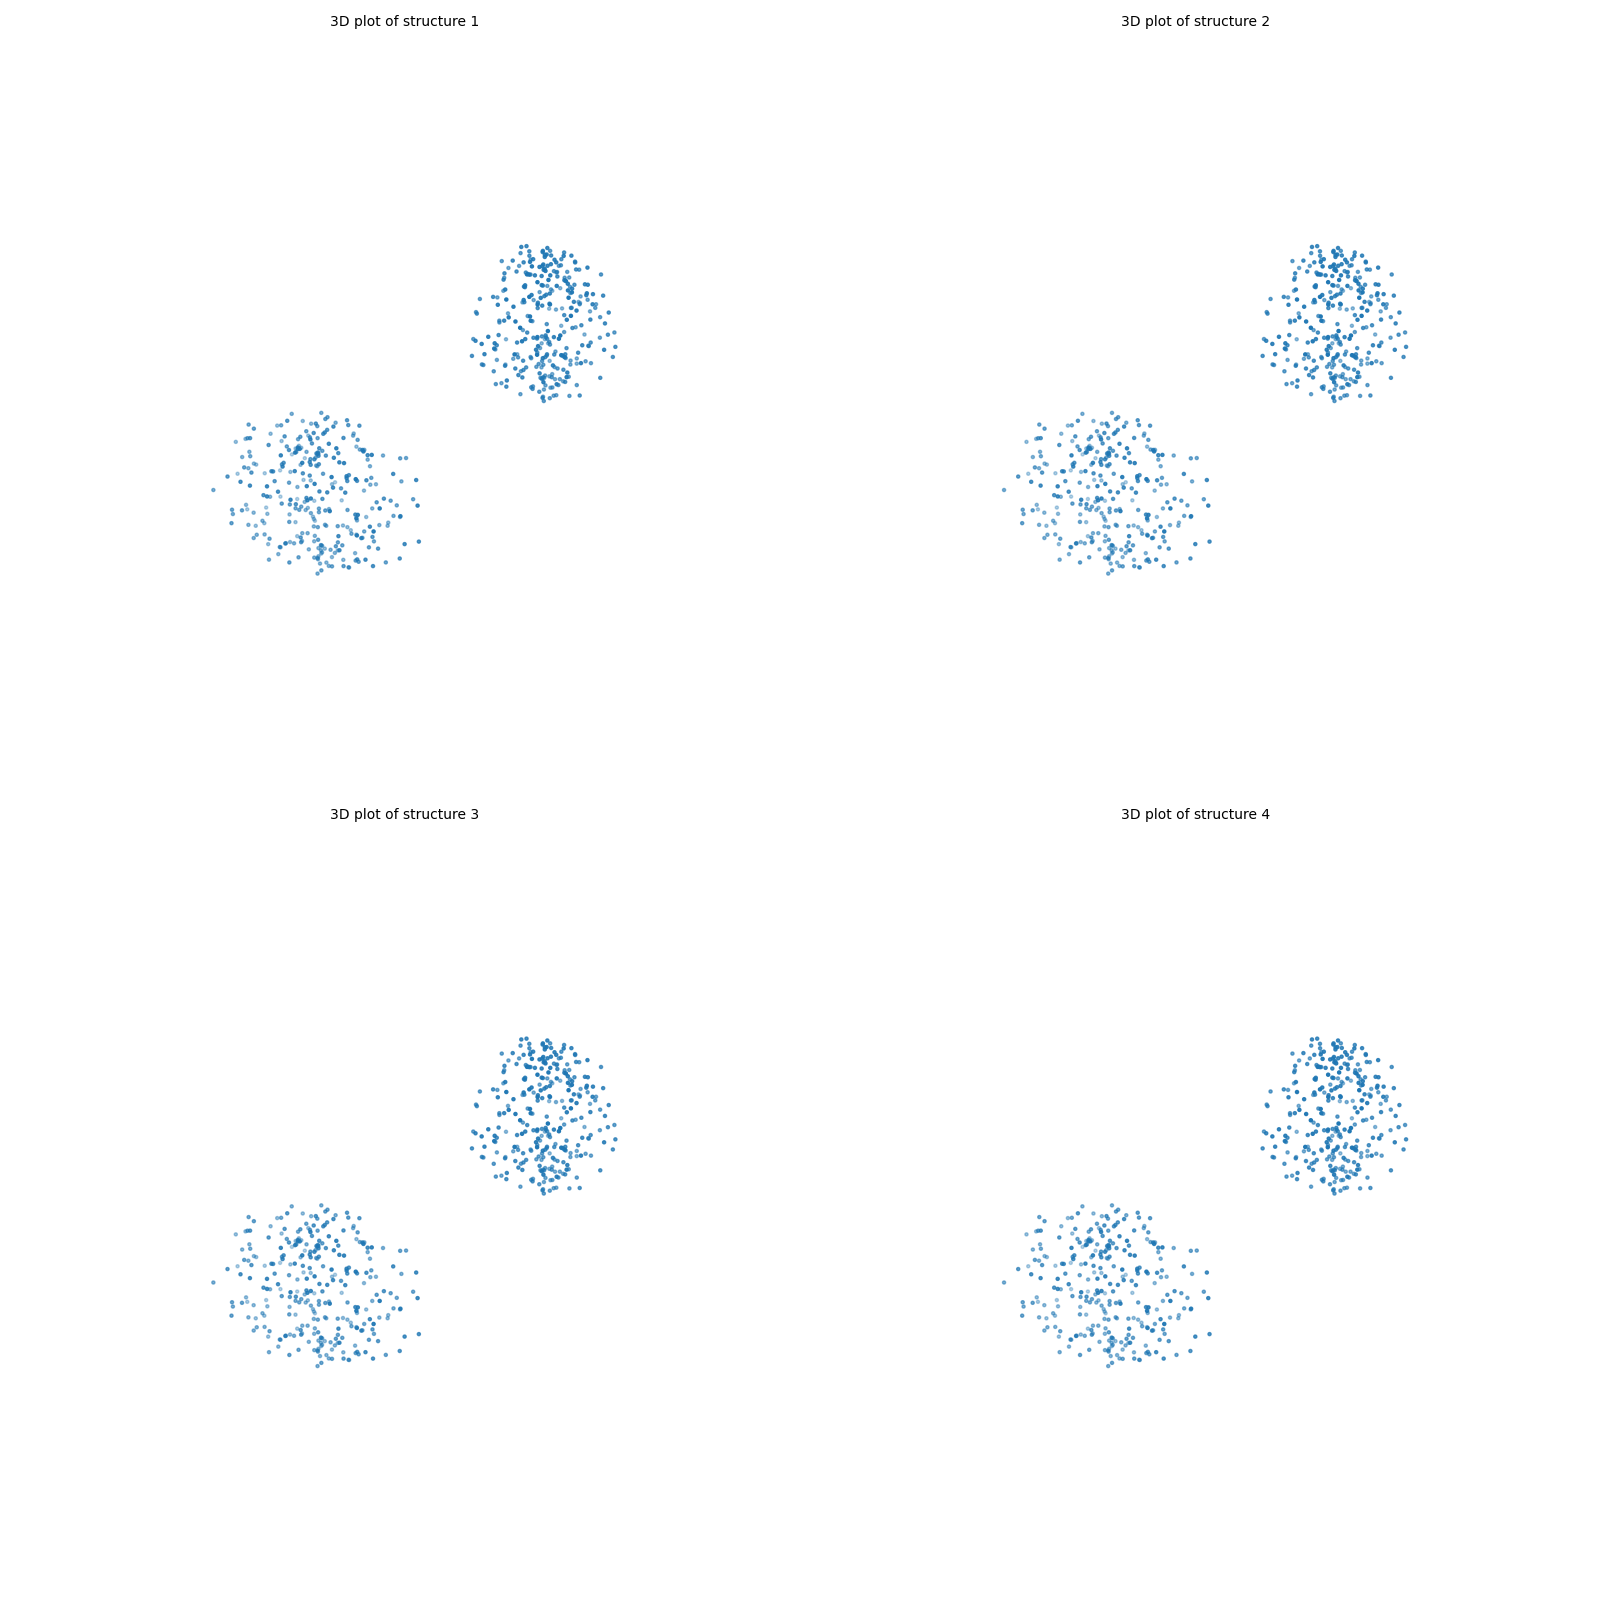

In [218]:
cov_ab = 0.01  # Covariance between a/c and b/c
variance_a = 0.1  # Variance for a/c
variance_b = 0.1  # Variance for b/c

mean_a = mean_b = 1
mean = [mean_a, mean_b] # a/c, b/c
cov = [[variance_a, cov_ab], 
       [cov_ab, variance_b]]

a = ellipsoid(1, 300, mean, cov, distribution='lognormal')
print(a.shape)
s = sphere(1,300)
print(s.shape)
s = s + 2
combi = np.vstack((a,s))
plt.close
plot_structure(combi,combi,combi,combi)

In [149]:
atomic_symbols = ["cl"] * len(a)
def write_xyz(filename, symbols, coords):
    num_atoms = len(symbols)
    with open(filename, 'w') as f:
        # First line: number of atoms
        f.write(f"{num_atoms}\n")
        # Second line: comment (optional)
        f.write("All carbon atoms\n")
        # Remaining lines: atomic symbol and coordinates
        for symbol, (x, y, z) in zip(symbols, coords):
            f.write(f"{symbol} {x:.6f} {y:.6f} {z:.6f}\n")

# Generate the XYZ file
write_xyz("sphere.xyz", atomic_symbols, a)

print("XYZ file for carbon atoms generated!")

XYZ file for carbon atoms generated!
